In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableTracingHardExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import seaborn as sns
import torch.distributions.constraints as constraints

sns.set()

pcache = PickleCache()

In [4]:
all_names = set(string.ascii_lowercase) - set(['l'])
all_operators = ['+', '-']

def generate_trial(N):
    names = sample(all_names, k=N)

    prog = ''
    for i in range(N):
        op = choice(all_operators)
        
        def gen_operand():
            if i > 0 and flip(p=0.5):
                return choice(names[:i])
            else:
                return randint(1, 9)
        
        left = gen_operand()
        right = gen_operand()
        prog += f'{names[i]} = {left} {op} {right}\n'

    expr_var_order = sample(names, k=len(names))
    operators = choices(all_operators, k=N-1)
    expr_list = []
    for i in range(N):
        if i > 0:
            op = operators[i-1]
            expr_list.append(op)
        expr_list.append(expr_var_order[i])
    expr = ' '.join(expr_list)
    
    locls = {}
    exec(prog, locls, locls)
    value = eval(expr, locls, locls)
    
    return {
        'prog': prog + expr,
        'value': value
    }

def exp_name(N_var, N_trials):
    return f'vartracehard_{N_var}_{N_trials}'

In [5]:
N_var = 5
N_trials = 10

experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableTracingHardExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableTracingHardExperiment(experiment='{"trials": [{"prog": "m = 3 - 9\\nq = 8 - m\\nj = 3 + m\\nk = q - m\…

In [6]:
def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    
    df = []
    for (trial, result) in zip(experiment['trials'], results):
        try:
            response = int(result['response'])
        except ValueError:
            response = -1000
                   
        correct = trial['value'] == response
        df.append({
            'N_var': N_var,
            'correct': correct,
            'response_time': result['response_time']/1000.,
            'type': 'actual'
        })
    return pd.DataFrame(df)

#process_results(N_var, N_trials)

In [7]:
all_exp = [2, 3, 4]
results = pd.concat([process_results(N_var, 10) for N_var in all_exp])

Text(0, 0.5, 'Response time (s)')

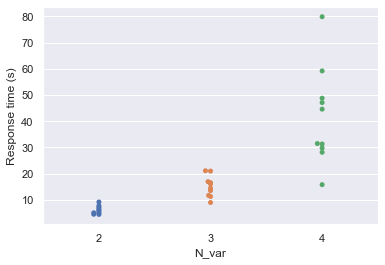

In [8]:
ax = sns.swarmplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')

In [9]:
results.groupby('N_var').mean()

,correct,response_time
N_var,,
2,0.9,6.1556
3,0.7,15.1802
4,0.5,41.6293


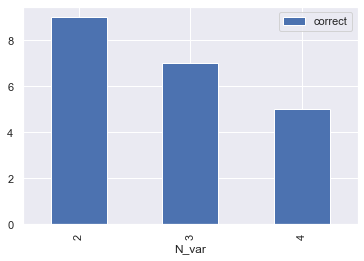

In [10]:
results.groupby('N_var').sum().plot.bar(y='correct')

In [11]:
results_sim = []
for N_var in tqdm(all_exp):
    data = pcache.get(exp_name(N_var, N_trials))
    for trial in data['experiment']['trials']:
        for _ in range(10):
            response_time = model(trial['prog'])
            results_sim.append({
                'response_time': response_time.item(),
                'N_var': N_var,
                'type': 'simulated'
            })
        
results_sim = pd.DataFrame(results_sim)
results_sim.groupby('N_var').mean()

,response_time
N_var,
2,9.540588
3,19.239950
4,38.097946


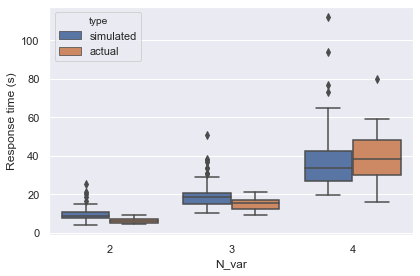

In [12]:
results_all = pd.concat([results_sim, results])
ax = sns.boxplot(data=results_all, x='N_var', y='response_time', hue='type')
ax.set_ylabel('Response time (s)')
plt.tight_layout()
plt.savefig('variable_tracing_hard.png', dpi=300)